# Fine Tuning Binary Classifiers
### Examples: Protest and John Legend

Andreu Casas and Nora Webb Williams | May, 2019

### Purpose:

To train binary visual classifiers predicting images with protesting crowds and with John Legend. A pre-trained Convolutional Neural Net predicting the 1,000 ImageNet classes (ResNet18) is adpated to predict binary outcomes by replacing the last 1,000-weights fully-connected layer with a layer that has only 2 weights, then fine-tuning the parameters on new training data.

### Paths & Constants

In [1]:
# - in this data directory there are 2 folders, one with the train-test images of each of 
#     the two classifiers: ['protest', 'legend'].
#     Each of these directories has a 'train' and 'test' subdirectory, and each of these two
#     subdirectories has a 'negative' and 'positive' subsubdirectories with the True Negative and 
#     True Positive images to train each classifier.

"""
data
  |
  |
   - protest
  |        |
  |        |
  |         - train
  |        |      |
  |        |       - negative
  |        |      |
  |        |       - positive
  |         - test
  |               |
  |                - negative
  |               |
  |                - positive                  
  |
   - legend 
   (... etc.)
"""
 
# NOTE: THE FOLLOWING ASSUMES THAT YOUR WORKING DIRECTORY IS THE ONE 
#       WHERE THIS NOTEBOOK IS LOCATED.
DATA_PATH = '../data/'
FUNCTIONS_PATH = '.'

In [2]:
import os
os.getcwd()

'/root/capsule/code/images_as_data/notebooks'

### Choices about which models to run and hyperparameters

In [15]:
# RESEARCHER CHOICES
# Which set of data do you want to train a model for? 
model_list = ['protest'] # Binary ICA 2019 options are 'protest', 'legend'

# Fine-tuning specification
num_classes = 2 # Enter the number of classes you are training for; will always be 2 for binary model
set_report_num = 1 # Enter how often you wish the program to report back as it iterates

# Hyperparameters
hyperparam_combo_num = 1 # Use this to keep track of which version of hyperparameters you are using 

set_learn_rate = 0.0001 # Enter the desired learning rate
set_momentum = .9 # Enter the desired momentum
set_step_size = 7 # Enter the desired step size
set_gamma = 0.1 # Enter the desired gamma
set_iterations = 10 # Enter the desired number of iterations
set_batch_size = 1 # Enter the desired batch size

### Modules

In [4]:
# Import all the needed python packages
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import numpy as np
plt.ion()   # interactive mode
import os
import pickle
import json
import pandas as pd
from PIL import Image

### Load Functions

In [5]:
# These are helper functions written by our team (mostly Andreu)
os.chdir(FUNCTIONS_PATH)
exec(open('00_functions.py', "rb").read())

### --MAIN-- Model Training

In [6]:
# MODEL TRAINING

In [7]:
# Report which model is being trained
print(model_list)

['protest']


In [8]:
# Specifying some objects that will be the same for any model
# - preprocessing to be applied to the images. See '00_functions.py' script
#   for more details on the 'data_transform()' function,
#   which primarily standardized image size
preprocess = data_tranform()
# - checking if the machine has GPUs
use_gpu = torch.cuda.is_available()

In [9]:
# - how often (every how many iterations) should the loop print/report accuracy
report_num = set_report_num

# These lines are useful if you build a big loop around the classification;
# You can ignore for now. Note that model_str will be the name you entered in model_list
# Iterate through the datasets and build binary image classifiers.
counter_models = 0
total_models = len(model_list)
model_str = model_list[0]

In [11]:
#================================================================
# INITIALIZE MODEL
#================================================================
# - load a pretrained model from TorchVision: ResNet18
model = models.resnet18(pretrained=True)

# - print the architecture of the model
model

ResNet (

  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

  (relu): ReLU (inplace)

  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))

  (layer1): Sequential (

    (0): BasicBlock (

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

      (relu): ReLU (inplace)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

    )

    (1): BasicBlock (

      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)

      (relu): ReLU (inplace)

      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

      

In [12]:
# - check number of features in last fully connected layer
num_ftrs = model.fc.in_features 

# - change the output layer from 1,000 classes to a binary outcome
model.fc = nn.Linear(num_ftrs, num_classes) # For ResNet18, last step is 512 -> 2

In [16]:
#================================================================
# MODEL HYPER-PARAMETERS
#================================================================
# - specify some model hyperparameters
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(model.parameters(), 
                         lr=set_learn_rate, 
                         momentum=set_momentum) # how to perform optimization
scheduler = lr_scheduler.StepLR(optimizer, 
                                       step_size=set_step_size, 
                                       gamma=set_gamma) # how to update learning rate    
# - number of iterations
iter_num = set_iterations

In [17]:
#================================================================
# PRE-PROCESSING
#================================================================
# - specify the path to data for this particular classifier
model_path = '%s/%s/'%(DATA_PATH, model_str)
# - specifying where the train and test images are
image_datasets = {x: datasets.ImageFolder(os.path.join(model_path, x),
                                          preprocess[x])
                  for x in ['train', 'test']}

# - creating an object to easily load the train and test images
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True)
              for x in ['train', 'test']}

# - getting some extra information such as the size of the dataset and the
#       class number
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

# - specify whether to use gpu 
if use_gpu:
    model = model.cuda()

In [18]:
#================================================================
# MODEL ESTIMATION
#================================================================
# - update counter and report progress
counter_models += 1
print('Training Model %s of %s: %s'%(counter_models, total_models, model_str.upper()))
print('=================================\n')

# - check the size of the train and test sets
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

# - initialize a time object so we can check how long the training 
#   takes
since = time.time()

# - initialize a matrix of weights (model parameters) and accuracy
#   object where we'll save the weights and accuracy info for the
#   most accurate weights-configuration
best_model_wts = model.state_dict()
best_acc = 0.0
best_precision = 0.0
best_recall = 0.0
loss_progress = []  
acc_progress = []


for iteration in range(iter_num):
    if iteration % report_num == 0:
        print('Iteration {}/{}'.format(iteration, iter_num - 1))
        print('-' * 10)

    # - each iteration has a training and testing phase
    for phase in ['train', 'test']:
        if phase == 'train':
            scheduler.step() # update model weights
            model.train(True)  # set model to training mode
        else:
            model.train(False)  # set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0
        running_preds = []
        running_labels = []

        # - iterate over data: in training iteration we
        #   iterate through groups of 4 train and 4 test
        #   images.
        for data in dataloaders[phase]:
            # - get the inputs
            inputs, labels = data

            # - transform data and labels into PyTorch variables
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            # - gradients back to 0 (re-calculated in each iteration)
            optimizer.zero_grad()

            # - forward propagation: applying dot products
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            preds_int_list = list(preds)
            labels_int_list = list(labels.data)                
            loss = criterion(outputs, labels)

            # (only in training phase)
            # - backward propagation: calculate loss and gradients
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # - calculate accuracy statistics
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == labels.data)
            running_preds = running_preds + preds_int_list
            running_labels = running_labels + labels_int_list

        iter_loss = running_loss / dataset_sizes[phase]
        iter_acc = running_corrects / dataset_sizes[phase]
        if sum(running_preds) > 0:
            iter_recall = sum([1 for i in range(0, len(running_preds)) if 
                                  running_preds[i] == 1 and 
                                  running_labels[i] == 1]) / float(sum(running_labels)) 
            iter_precision = sum([1 for i in range(0, len(running_preds)) if 
                                     running_preds[i] == 1 and 
                                     running_labels[i] == 1]) / float(sum(running_preds))
        else:
            iter_recall = 0
            iter_precision = 0

        # - report training progress once every N (e.g. 10) iterations
        if iteration % report_num == 0:
            print('{} Loss:{:.4f} Acc:{:.4f} Precision:{:.4f} Recall:{:.4f}\n'.format(
                phase, iter_loss, iter_acc, iter_precision, iter_recall))

        # - if this iteration's results are the best so far,
        #   saving a copy of this best model
        if phase == 'test' and iter_acc > best_acc:
            best_acc = iter_acc
            best_precision = iter_precision
            best_recall = iter_recall
            best_model_wts = model.state_dict()                
        if phase == 'test':
            # - keep track of the evolution of the loss and accuracy
            loss_progress.append(iter_loss)
            acc_progress.append(iter_acc)

    # - if the accuracy is already pretty high, move to next
    #   classifier
    if best_acc > 0.95 and best_precision > 0.95 and best_recall > 0.95:
        print('... reached good model accuracy, moving to next model.')
        break

# - check how long it took to estimate the model and report
#   time and results for the most accurate model weights
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}\n\n'.format(best_acc))    

Training Model 2 of 1: PROTEST




Iteration 0/9

----------

train Loss:0.1683 Acc:0.6353 Precision:0.6322 Recall:0.6471



test Loss:0.1197 Acc:0.8667 Precision:0.7895 Recall:1.0000



Iteration 1/9

----------

train Loss:0.1187 Acc:0.8412 Precision:0.8452 Recall:0.8353



test Loss:0.0696 Acc:0.9333 Precision:0.9333 Recall:0.9333



Iteration 2/9

----------

train Loss:0.0979 Acc:0.8647 Precision:0.8605 Recall:0.8706



test Loss:0.0654 Acc:0.9667 Precision:0.9375 Recall:1.0000



Iteration 3/9

----------

train Loss:0.0883 Acc:0.8412 Precision:0.8222 Recall:0.8706



test Loss:0.0505 Acc:0.9333 Precision:0.9333 Recall:0.9333



Iteration 4/9

----------

train Loss:0.0858 Acc:0.8235 Precision:0.8161 Recall:0.8353



test Loss:0.0637 Acc:0.9333 Precision:0.9333 Recall:0.9333



Iteration 5/9

----------

train Loss:0.0807 Acc:0.8765 Precision:0.8636 Recall:0.8941



test Loss:0.0440 Acc:0.9333 Precision:0.9333 Recall:0.9333



Iteration 6/9

----------

train Loss:0.0670 Acc:0.88

In [19]:
# - use the best model to predict labels for the whole
#   test set and calculate precision and recall of the
#   binary classifier   

# - save the best model weights and accuracy
model.load_state_dict(best_model_wts)
accuracy_summary = {'acc':best_acc,
                      'precision':best_precision,
                      'recall':best_recall,
                      'lr':set_learn_rate,
                      'momentum':set_momentum,
                      'step_size':set_step_size,
                      'gamma':set_gamma,
                      'max_iters':set_iterations,
                      'batch_size':set_batch_size, 
                      'acc_progress':acc_progress,
                      'loss_progress':loss_progress
                      }

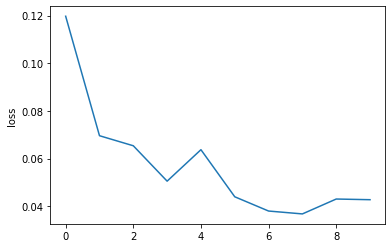

In [21]:
# - take a look at the evolution of the model loss
plt.plot(loss_progress)
plt.ylabel('loss')
plt.show()
plt.show()

### Take a look at some model predictions

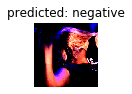

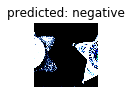

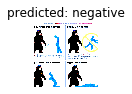

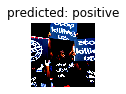

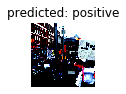

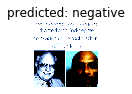

In [23]:
visualize_model(model = model,
                class_names = class_names,
                num_images = 6,
                dataloaders = dataloaders,
                use_gpu = use_gpu)

### Saving, loading, and using the trained model later

In [ ]:
# - PyTorch comes with a function to easily save models
#torch.save(model, '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))

In [24]:
# - here is how you can reload the model again
#model_new = torch.load(
#    '%s/MODELS/%s.pth'%(DATA_PATH, model_str + '_' + str(hyperparam_combo_num)))
model_new = model

In [25]:
# USING THE MODEL TO MAKE NEW PREDICTIONS
# - load some example images to test how to use, on a new set of images, a model you previously trained
pos_path = '%s%s/test/positive/'%(DATA_PATH, model_str)
neg_path = '%s%s/test/negative/'%(DATA_PATH, model_str)
pos_list = ['%s%s'%(pos_path, x) for x in os.listdir(pos_path)[:5]]
neg_list = ['%s%s'%(neg_path, x) for x in os.listdir(neg_path)[:5]]
test_img_path_list = pos_list + neg_list
new_dataset = []
for img_file in test_img_path_list:
    img = Image.open(img_file).convert('RGB')
    new_dataset.append(img)

In [26]:
# - specifying the transformation-preprocessing to apply to the images
preprocess = data_tranform(train = False)

# - checking if the machine has GPUs and enabling GPU computing if so
use_gpu = torch.cuda.is_available()

In [27]:
# - use the model to perform predictions on this "new" set of images
# ... initialize output dataset and a counter
softmax = nn.Softmax()
output_data = pd.DataFrame()
counter = 0
total = len(new_dataset)
# ... iterate through the new images to predict
for z in range(0, len(new_dataset)):
    counter += 1
    print('image: %s/%s'%(counter, total))
    img_filename = test_img_path_list[z]
    img = new_dataset[z]
    # ... initialize output dict object for this iteration/img
    new_entry = {}
    # ... transform-preprocess this imags
    var = Variable(preprocess(img).unsqueeze(0))
    # ... make the model prediction
    pred = model_new(var.cuda())
    # ... pull the predicted class probabilities and create a dataframe with them
    probs, indeces = softmax(pred).data.sort()
    probs = [round(x, 3) for x in list(probs[0])]
    indeces = list(indeces[0][:2])
    labels = [['negative', 'positive'][i] for i in indeces]
    pred_df = pd.DataFrame({'label':labels,
                            'probs':probs})
    pred_df_t = pred_df.transpose()
    final_pred_df = pd.DataFrame(pred_df_t.iloc[1]).transpose()    
    final_pred_df.columns = labels
    # ... adding some extra information about the image and prediction
    final_pred_df['img'] = '/'.join(img_filename.split('/')[-2:])
    final_pred_df['max_class'] = ['negative', 'positive'][indeces[1]]
    final_pred_df['max_pr'] = max(probs)
    output_data = pd.concat([output_data, final_pred_df])
output_data = output_data.reset_index(drop=True)

image: 1/10

image: 2/10

image: 3/10

image: 4/10

image: 5/10

image: 6/10

image: 7/10

image: 8/10

image: 9/10

image: 10/10


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version

of pandas will change to not sort by default.



To accept the future behavior, pass 'sort=False'.



To retain the current behavior and silence the warning, pass 'sort=True'.




In [28]:
output_data

,img,max_class,max_pr,negative,positive
0,positive/53260.jpg,positive,0.893,0.107,0.893
1,positive/52723.jpg,positive,0.980,0.02,0.98
2,positive/5393.jpg,negative,0.771,0.771,0.229
3,positive/50988.jpg,positive,0.971,0.029,0.971
4,positive/37456.jpg,positive,0.979,0.021,0.979
5,negative/7700.jpg,negative,0.984,0.984,0.016
6,negative/1477.jpg,negative,0.903,0.903,0.097
7,negative/954.jpg,negative,0.959,0.959,0.041
8,negative/7896.jpg,negative,0.986,0.986,0.014
9,negative/3019.jpg,negative,0.982,0.982,0.018
